## Demo_ACT
This is a demo for visualizing the dense plot of hessian matrix for a batch of data.

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py --save_folder_name badnet_demo

or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

### Step 1: Import modules and set arguments

In [1]:
import sys, os
import yaml
import torch
import numpy as np
import torchvision.transforms as transforms

sys.path.append("../")
sys.path.append("../../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel
from pyhessian import hessian # Hessian computation

In [2]:
### Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load data

In [3]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
selected_classes = np.arange(args.num_classes)

# Select classes to visualize
if args.num_classes > args.c_sub:
    selected_classes = np.delete(selected_classes, args.target_class)
    selected_classes = np.random.choice(
        selected_classes, args.c_sub-1, replace=False)
    selected_classes = np.append(selected_classes, args.target_class)

# keep the same transforms for train and test dataset for better visualization
result_attack["clean_train"].wrap_img_transform = result_attack["clean_test"].wrap_img_transform 
result_attack["bd_train"].wrap_img_transform = result_attack["bd_test"].wrap_img_transform 

# Create dataset
if args.visual_dataset == 'clean_train':
    visual_dataset = result_attack["clean_train"]
elif args.visual_dataset == 'clean_test':
    visual_dataset = result_attack["clean_test"]
elif args.visual_dataset == 'bd_train':
    visual_dataset = result_attack["bd_train"]
elif args.visual_dataset == 'bd_test':
    visual_dataset = result_attack["bd_test"]
else:
    assert False, "Illegal vis_class"

print(
    f'Create visualization dataset with \n \t Dataset: {args.visual_dataset} \n \t Number of samples: {len(visual_dataset)}  \n \t Selected classes: {selected_classes}')

# Create data loader
data_loader = torch.utils.data.DataLoader(
    visual_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

# Create denormalization function
for trans_t in data_loader.dataset.wrap_img_transform.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)



Files already downloaded and verified
Files already downloaded and verified
loading...
Create visualization dataset with 
 	 Dataset: bd_train 
 	 Number of samples: 50000  
 	 Selected classes: [0 1 2 3 4 5 6 7 8 9]


### Step 3: Load Model

In [4]:
# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual.to(args.device)
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")

Load model preactresnet18 from badnet_demo


### Step 4: Plot Eigenvalues of Hessian

Adapted from https://github.com/amirgholami/PyHessian/blob/master/Hessian_Tutorial.ipynb

In [5]:
def old_torcheig(A, eigenvectors):
    '''A temporary function as an alternative for torch.eig (torch<=1.9)'''
    vals, vecs = torch.linalg.eig(A)
    if torch.is_complex(vals) or torch.is_complex(vecs):
        print('Warning: Complex values founded in Eigenvalues/Eigenvectors. This is impossible for real symmetric matrix like Hessian. \n We only keep the real part.')

    vals = torch.real(vals)
    vecs = torch.real(vecs)

    # vals is a nx2 matrix. see https://virtualgroup.cn/pytorch.org/docs/stable/generated/torch.eig.html
    vals = vals.view(-1,1)+torch.zeros(vals.size()[0],2).to(vals.device)
    if eigenvectors:
        return vals, vecs
    else:
        return vals, torch.tensor([])
    
torch.eig = old_torcheig

/usr/local/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1059.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


The top two eigenvalues of this model are: 36.4870 71.8704
 We only keep the real part.


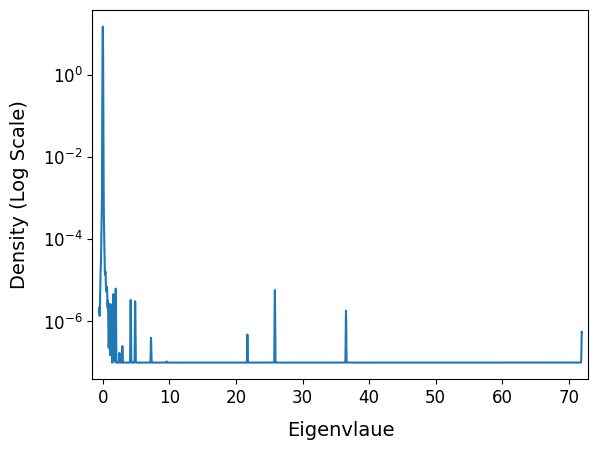

In [6]:
def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    return plt.gca()

def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

criterion = torch.nn.CrossEntropyLoss()

# get a batch of data for computing the Hessian
batch_x, batch_y, *others = next(iter(data_loader))
batch_x = batch_x.to(args.device)
batch_y = batch_y.to(args.device)

# create the hessian computation module
hessian_comp = hessian(model_visual, criterion, data=(batch_x, batch_y), cuda=True)
# Now let's compute the top 2 eigenavlues and eigenvectors of the Hessian
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(top_n=2, maxIter=1000)
print("The top two eigenvalues of this model are: %.4f %.4f"% (top_eigenvalues[-1],top_eigenvalues[-2]))

density_eigen, density_weight = hessian_comp.density()

   
ax = get_esd_plot(density_eigen, density_weight)
